# DeePMD-kit Quick Start Tutorial

<a href="https://bohrium.dp.tech/notebook/b2223fcc549741d986e912c94cd82231" target="_blank"><img src="https://cdn.dp.tech/bohrium/web/static/images/open-in-bohrium.svg" alt="Open In Bohrium"/></a>

**DeePMD-kit is a deep learning package for many-body potential energy representation and molecular dynamics.**

> This tutorial can be directly run on **Bohrium Notebook**, you can click the `Open in Bohrium` button above to quickly run this document in Bohrium.
>
> After opening Bohrium Notebook, click the button `connect`, and choose `deepmd-kit:2.2.1-cuda11.6-notebook` as image and `c4_m8_cpu` as computing resources. Wait a minute and you can get started.


## Task

> **Mastering the paradigm cycle of using DeePMD-kit to establish deep potential molecular dynamics models, and following a complete case to learn how to apply it to molecular dynamics tasks.**

By the end of this tutorial, you will be able to:

* Prepare the formataive dataset and running scripts for training with DeePMD-kit;
* Train, freeze, and test DeePMD-kit models;
* Use DeePMD-kit in LAMMPS for calculations;

Work through this tutorial. It will take you 20 minutes, max!

## Table of contents

* Get tutorial data via git
* General Introduction
* Data preparation
* Prepare input script
* Train a model
* Freeze a model
* Test a model
* Run MD with LAMMPS

## Get tutorial data via git

In [1]:
! if ! [ -e colombo-academy-tutorials ];then git clone https://gitee.com/deepmodeling/colombo-academy-tutorials.git;fi;

Cloning into 'colombo-academy-tutorials'...
remote: Enumerating objects: 7164, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 7164 (delta 78), reused 71 (delta 32), pack-reused 6990
Receiving objects: 100% (7164/7164), 45.31 MiB | 3.85 MiB/s, done.
Resolving deltas: 100% (3378/3378), done.
Updating files: 100% (185/185), done.


## General Introduction
This tutorial will introduce you to the basic usage of the DeePMD-kit, taking a gas phase methane molecule as an example. [DeePMD-kit's documentation](https://docs.deepmodeling.org/projects/deepmd/ 
) is recommended as the complete reference.

The DP model is generated using the DeePMD-kit package (v2.1.5). The training data is converted into the format of DeePMD-kit using a tool named dpdata (v0.2.14). 

Details of dpdata can be found in [the dpdata documentation](https://docs.deepmodeling.com/projects/dpdata). 

We've prepared initial data for $CH_4$ for you, and put them in the folder `colombo-academy-tutorials/DeePMD-kit/00.data`

In [2]:
import os

prefix_path = os.getcwd()

Folder `abacus_md` is obtained by performing ab-initio molecular dynamics with ABACUS. Detailed instructions on ABACUS can be found in its [document](https://abacus.deepmodeling.com/en/latest/). 

In [3]:
os.chdir(
    os.path.join(prefix_path, "colombo-academy-tutorials", "DeePMD-kit", "00.data")
)
os.listdir("abacus_md")

['C_ONCV_PBE-1.2.upf',
 'C_gga_6au_100Ry_2s2p1d.orb',
 'H_ONCV_PBE-1.2.upf',
 'H_gga_6au_100Ry_2s1p.orb',
 'INPUT',
 'KPT',
 'OUT.ABACUS',
 'STRU']

## Data preparation

The training data utilized by DeePMD-kit comprises essential information such as atom type, simulation box, atom coordinate, atom force, system energy, and virial. A snapshot of a molecular system that includes this data is called a `frame`. Multiple frames with the same number of atoms and atom types make up a `system` of data. For instance, a molecular dynamics trajectory can be converted into a system of data, with each time step corresponding to a frame in the system.

To simplify the process of converting data generated by popular simulation software like CP2K, Gaussian, Quantum-Espresso, ABACUS, and LAMMPS into the compressed format of DeePMD-kit, we offer a convenient tool called `dpdata`.


Next, the data from AIMD is splited randomly as training and validation data.

In [4]:
import dpdata
import numpy as np

# load data of abacus/md format
data = dpdata.LabeledSystem("abacus_md", fmt="abacus/md")
print("# the data contains %d frames" % len(data))

# random choose 40 index for validation_data
index_validation = np.random.choice(201, size=40, replace=False)

# other indexes are training_data
index_training = list(set(range(201)) - set(index_validation))
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)

# all training data put into directory:"training_data"
data_training.to_deepmd_npy("training_data")

# all validation data put into directory:"validation_data"
data_validation.to_deepmd_npy("validation_data")

print("# the training data contains %d frames" % len(data_training))
print("# the validation data contains %d frames" % len(data_validation))

# the data contains 201 frames
# the training data contains 161 frames
# the validation data contains 40 frames


As you can see, 161 frames are picked as training data, and the other 40 frames are validation dat.

The DeePMD-kit adopts a compressed data format. All training data should first be converted into this format and can then be used by DeePMD-kit. The data format is explained in detail in the DeePMD-kit manual that can be found in [the DeePMD-kit Data Introduction](../data/index.md).

In [5]:
! tree training_data

training_data
├── set.000
│   ├── box.npy
│   ├── coord.npy
│   ├── energy.npy
│   ├── force.npy
│   └── virial.npy
├── type.raw
└── type_map.raw

1 directory, 7 files


Let's have a look at `type.raw`:

In [6]:
! cat training_data/type.raw

0
0
0
0
1


This tells us there are 5 atoms in this example, 4 atoms represented by type "0", and 1 atom represented by type "1".
Sometimes one needs to map the integer types to atom name. The mapping can be given by the file `type_map.raw`

In [7]:
! cat training_data/type_map.raw

H
C


This tells us the type "0" is named by "H", and the type "1" is named by "C".

More detailed doc about Data conversion can be found [here](../data/data-conv.md).

## Prepare input script 
Once the data preparation is done, we can go on with training. Now go to the training directory

In [8]:
os.chdir(
    os.path.join(prefix_path, "colombo-academy-tutorials", "DeePMD-kit", "01.train")
)

DeePMD-kit requires a `json` format file to specify parameters for training. 

In the model section, the parameters of embedding and fitting networks are specified.
```json
"model":{
    "type_map":    ["H", "C"],                 
    "descriptor":{
        "type":            "se_e2_a",          
        "rcut":            6.00,               
        "rcut_smth":       0.50,               
        "sel":             "auto",             
        "neuron":          [25, 50, 100],       
        "resnet_dt":       false,
        "axis_neuron":     16,                  
        "seed":            1,
        "_comment":        "that's all"
        },
    "fitting_net":{
        "neuron":          [240, 240, 240],    
        "resnet_dt":       true,
        "seed":            1,
        "_comment":        "that's all"
    },
    "_comment":    "that's all"'
},
```
The explanation for some of the parameters is as follows:

| Parameter                | Expiation                                                    |
| ------------------------ | ------------------------------------------------------------ |
| type_map                 | *the* *name* *of* *each* *type* *of* *atom*                  |
| descriptor > type        | *the* *type* *of* *descriptor*                               |
| descriptor > rcut        | *cut-off* *radius*                                           |
| descriptor > rcut_smth   | *where* *the* *smoothing* *starts*                           |
| descriptor > sel         | *the* *maximum* *number* *of* *type* *i* *atoms* *in* *the* *cut-off* *radius* |
| descriptor > neuron      | *size* *of* *the* *embedding* *neural* *network*             |
| descriptor > axis_neuron | *the* *size* *of* *the* *submatrix* *of* *G* *(embedding* *matrix)* |
| fitting_net > neuron     | *size* *of* *the* *fitting* *neural* *network*               |

The `se_e2_a` descriptor is used to train the DP model. The item neurons set the size of the descriptors and fitting network to [25, 50, 100] and [240, 240, 240], respectively. The components in local environment to smoothly go to zero from 0.5 to 6 Å.

The following are the parameters that specify the learning rate and loss function.
```json
    "learning_rate" :{
        "type":                "exp",
        "decay_steps":         50,
        "start_lr":            0.001,    
        "stop_lr":             3.51e-8,
        "_comment":            "that's all"
    },
    "loss" :{
        "type":                "ener",
        "start_pref_e":        0.02,
        "limit_pref_e":        1,
        "start_pref_f":        1000,
        "limit_pref_f":        1,
        "start_pref_v":        0,
        "limit_pref_v":        0,
        "_comment":            "that's all"
    },
```
In the loss function, `pref_e` increases from 0.02 to 1, and `pref_f` decreases from 1000 to 1  progressively, which means that the force term dominates at the beginning, while energy and virial terms become important at the end. This strategy is very effective and reduces the total training time. `pref_v` is set to 0 , indicating that no virial data are included in the training process. The starting learning rate, stop learning rate, and decay steps are set to 0.001, 3.51e-8, and 50, respectively. The model is trained for 10000 steps.

The training parameters are given in the following
```json
    "training" : {
        "training_data": {
            "systems":            ["../00.data/training_data"],     
            "batch_size":         "auto",                       
            "_comment":           "that's all"
        },
        "validation_data":{
            "systems":            ["../00.data/validation_data/"],
            "batch_size":         "auto",               
            "numb_btch":          1,
            "_comment":           "that's all"
        },
        "numb_steps":             10000,                           
        "seed":                   10,
        "disp_file":              "lcurve.out",
        "disp_freq":              200,
        "save_freq":              10000,
        },
```

More detailed docs about Data conversion can be found [here](https://docs.deepmodeling.org/projects/deepmd/en/master/data/data-conv.html).

## Train a model
After the training script is prepared, we can start the training with DeePMD-kit by simply running

In [9]:
! dp train input.json

Instructions for updating:
non-resource variables are not supported in the long term
/opt/deepmd-kit-2.2.1/lib/python3.10/importlib/__init__.py:169: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)
DEEPMD INFO    Calculate neighbor statistics... (add --skip-neighbor-stat to skip this step)
2023-04-20 23:35:59.335932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-20 23:35:59.335979: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
OMP: Info #155: KMP_AFFINITY: Initial OS proc set respected: 0-7
OMP: Info #216: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #216: KMP_AFFINITY: cpuid leaf 11 not suppor

On the screen, you will see the information of the data system(s)
```
DEEPMD INFO    -----------------------------------------------------------------
DEEPMD INFO    ---Summary of DataSystem: training     ----------------------------------
DEEPMD INFO    found 1 system(s):
DEEPMD INFO                                 system  natoms  bch_sz   n_bch   prob  pbc
DEEPMD INFO               ../00.data/training_data       5       7      23  1.000    T
DEEPMD INFO    -------------------------------------------------------------------------
DEEPMD INFO    ---Summary of DataSystem: validation   ----------------------------------
DEEPMD INFO    found 1 system(s):
DEEPMD INFO                                 system  natoms  bch_sz   n_bch   prob  pbc
DEEPMD INFO             ../00.data/validation_data       5       7       5  1.000    T
DEEPMD INFO    -------------------------------------------------------------------------
```
and the starting and final learning rate of this training
```
DEEPMD INFO    start training at lr 1.00e-03 (== 1.00e-03), decay_step 50, decay_rate 0.950006, final lr will be 3.51e-08
```
If everything works fine, you will see, on the screen, information printed every 1000 steps, like
```
DEEPMD INFO    batch     200 training time 6.04 s, testing time 0.02 s
DEEPMD INFO    batch     400 training time 4.80 s, testing time 0.02 s
DEEPMD INFO    batch     600 training time 4.80 s, testing time 0.02 s
DEEPMD INFO    batch     800 training time 4.78 s, testing time 0.02 s
DEEPMD INFO    batch    1000 training time 4.77 s, testing time 0.02 s
DEEPMD INFO    saved checkpoint model.ckpt
DEEPMD INFO    batch    1200 training time 4.47 s, testing time 0.02 s
DEEPMD INFO    batch    1400 training time 4.49 s, testing time 0.02 s
DEEPMD INFO    batch    1600 training time 4.45 s, testing time 0.02 s
DEEPMD INFO    batch    1800 training time 4.44 s, testing time 0.02 s
DEEPMD INFO    batch    2000 training time 4.46 s, testing time 0.02 s
DEEPMD INFO    saved checkpoint model.ckpt
```
They present the training and testing time counts. At the end of the 1000th batch, the model is saved in Tensorflow's checkpoint file `model.ckpt`. At the same time, the training and testing errors are presented in file `lcurve.out`. 

The file contains 8 columns, form left to right, are the training step, the validation loss, training loss, root mean square (RMS) validation error of energy, RMS training error of energy, RMS validation error of force, RMS training error of force and the learning rate. The RMS error (RMSE) of the energy is normalized by number of atoms in the system. 
```
head -n 2 lcurve.out
#  step      rmse_val    rmse_trn    rmse_e_val  rmse_e_trn    rmse_f_val  rmse_f_trn         lr
      0      2.02e+01    1.51e+01      1.37e-01    1.41e-01      6.40e-01    4.79e-01    1.0e-03
```
and
```
$ tail -n 2 lcurve.out
   9800      2.45e-02    4.02e-02      3.20e-04    3.88e-04      2.40e-02    3.94e-02    4.3e-08
  10000      4.60e-02    3.76e-02      8.65e-04    5.35e-04      4.52e-02    3.69e-02    3.5e-08
```
Volumes 4, 5 and 6, 7 present energy and force training and testing errors, respectively. 

In [10]:
! head -n 2 lcurve.out && tail -n 2 lcurve.out

#  step      rmse_val    rmse_trn    rmse_e_val  rmse_e_trn    rmse_f_val  rmse_f_trn         lr
      0      2.06e+01    1.94e+01      1.34e-01    1.35e-01      6.51e-01    6.14e-01    1.0e-03
   9800      5.49e-02    4.00e-02      7.55e-04    7.28e-04      5.37e-02    3.91e-02    4.3e-08
  10000      6.56e-02    6.37e-02      1.13e-03    1.54e-03      6.44e-02    6.25e-02    3.5e-08


The loss function can be visualized to monitor the training process.

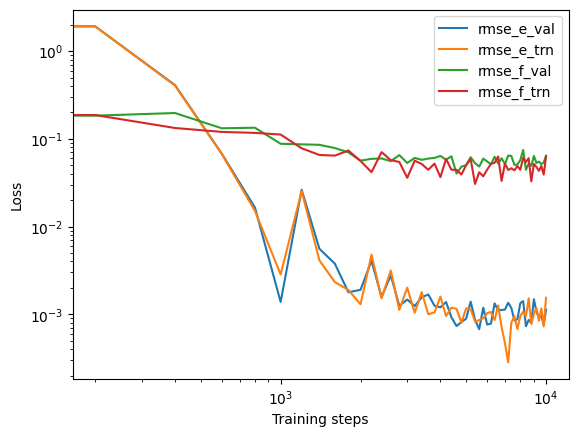

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

with open("lcurve.out") as f:
    headers = f.readline().split()[1:]
lcurve = pd.DataFrame(np.loadtxt("lcurve.out"), columns=headers)
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
for legend in legends:
    plt.loglog(lcurve["step"], lcurve[legend], label=legend)
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

## Freeze a model

At the end of the training, the model parameters saved in TensorFlow's checkpoint file should be frozen as a model file that is usually ended with extension `.pb`. Simply execute

In [12]:
! dp freeze -o graph.pb

Instructions for updating:
non-resource variables are not supported in the long term
/opt/deepmd-kit-2.2.1/lib/python3.10/importlib/__init__.py:169: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)
2023-04-20 23:40:25.666203: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-20 23:40:25.666257: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
DEEPMD INFO    The following nodes will be frozen: ['model_type', 'descrpt_attr/rcut', 'descrpt_attr/ntypes', 'model_attr/tmap', 'model_attr/model_type', 'model_attr/model_version', 'train_attr/min_nbor_dist', 'train_attr/training_script', 'o_energy', 'o_force', 

and it will output a model file named `graph.pb` in the current directory. 

## Test a model 

We can check the quality of the trained model by running


In [13]:
! dp test -m graph.pb -s ../00.data/validation_data

Instructions for updating:
non-resource variables are not supported in the long term
/opt/deepmd-kit-2.2.1/lib/python3.10/importlib/__init__.py:169: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)
2023-04-20 23:40:30.102300: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-20 23:40:30.102346: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
DEEPMD WARNING You can use the environment variable DP_INFER_BATCH_SIZE tocontrol the inference batch

The correlation between predicted data and original data can also be calculated.

In [14]:
import dpdata

training_systems = dpdata.LabeledSystem("../00.data/training_data", fmt="deepmd/npy")

In [15]:
predict = training_systems.predict("graph.pb")

2023-04-20 23:40:32.104716: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 23:40:34.426193: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-20 23:40:34.427318: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-20 23:40:34.427332: W 

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-04-20 23:40:36.161142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 23:40:36.165078: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-20 23:40:36.165119: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-20 23:40:36.165142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bohrium-14076-1013950): /proc/driver/nvidia/version does 

[]

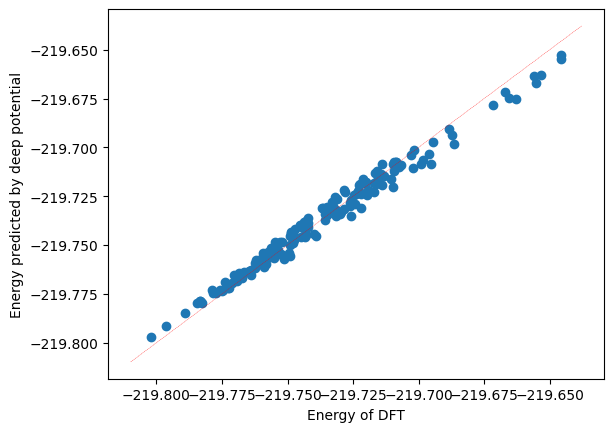

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(training_systems["energies"], predict["energies"])

x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])

plt.plot(x_range, x_range, "r--", linewidth=0.25)
plt.xlabel("Energy of DFT")
plt.ylabel("Energy predicted by deep potential")
plt.plot()

## Run MD with LAMMPS

The model can drive molecular dynamics in LAMMPS. 


In [17]:
! cd ../02.lmp && cp ../01.train/graph.pb ./ && ls

conf.lmp  graph.pb  in.lammps


Here `conf.lmp` gives the initial configuration of a gas phase methane MD simulation, and the file `in.lammps` is the LAMMPS input script. One may check in.lammps and finds that it is a rather standard LAMMPS input file for a MD simulation, with only two exception lines:
```
pair_style  deepmd graph.pb
pair_coeff  * *
```
where the pair style deepmd is invoked and the model file `graph.pb` is provided, which means the atomic interaction will be computed by the DP model that is stored in the file `graph.pb`. 

In an environment with a compatible version of LAMMPS, the deep potential molecular dynamics can be performed via 

```bash
lmp -i input.lammps
```

In [18]:
! cd ../02.lmp && cp ../01.train/graph.pb ./ && lmp -i in.lammps

This LAMMPS executable is in a conda environment, but the environment has
not been activated. Libraries may fail to load. To activate this environment
please see https://conda.io/activation.
LAMMPS (23 Jun 2022 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Loaded 1 plugins from /opt/deepmd-kit-2.2.1/lib/deepmd_lmp
Reading data file ...
  triclinic box = (0 0 0) to (10.114259 10.263124 10.216793) with tilt (0.036749877 0.13833062 -0.056322169)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  5 atoms
  read_data CPU = 0.004 seconds
DeePMD-kit WARNING: Environmental variable OMP_NUM_THREADS is not set. Tune OMP_NUM_THREADS for the best performance. See https://deepmd.rtfd.io/parallelism/ for more information.
Summary of lammps deepmd module ...
  >>> Info of deepmd-kit:
  installed to:       /opt/deepmd-kit-2.2.1
  source:             v2.2.1
  source branch:       HEAD
  source commit:      3ac8c

<a href="https://bohrium.dp.tech/notebook/b2223fcc549741d986e912c94cd82231" target="_blank"><img src="https://cdn.dp.tech/bohrium/web/static/images/open-in-bohrium.svg" alt="Open In Bohrium"/></a>